### Example 1: The results of nonlinear plant identification using series-parallel model

##### Import Essential Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

#####  Define neural networks for N_f and N_g

In [2]:
class NeuralNetworkF(nn.Module):
    def __init__(self):
        super(NeuralNetworkF, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

class NeuralNetworkG(nn.Module):
    def __init__(self):
        super(NeuralNetworkG, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.ReLU()
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

# Instantiate networks
net_f = NeuralNetworkF()
net_g = NeuralNetworkG()

# Optimizers and loss function
optimizer_f = optim.Adam(net_f.parameters(), lr=0.01)
optimizer_g = optim.Adam(net_g.parameters(), lr=0.01)
criterion = nn.MSELoss()

##### Generate and Format Training Data for Function Approximation

In [3]:
# Generate training data for N_f and N_g
y_values = np.linspace(-10, 10, 1000)
u_values = np.linspace(-2, 2, 1000)
f_values = y_values / (1 + y_values ** 2)
g_values = u_values ** 3

# Convert data to torch tensors
y_train = torch.tensor(y_values, dtype=torch.float32).view(-1, 1)
f_train = torch.tensor(f_values, dtype=torch.float32).view(-1, 1)
u_train = torch.tensor(u_values, dtype=torch.float32).view(-1, 1)
g_train = torch.tensor(g_values, dtype=torch.float32).view(-1, 1)

##### Training the Neural Network and Generating Model Outputs 

In [4]:
# Train N_f
epochs = 1000
for epoch in range(epochs):
    optimizer_f.zero_grad()
    output_f = net_f(y_train)
    loss_f = criterion(output_f, f_train)
    loss_f.backward()
    optimizer_f.step()

# Train N_g
for epoch in range(epochs):
    optimizer_g.zero_grad()
    output_g = net_g(u_train)
    loss_g = criterion(output_g, g_train)
    loss_g.backward()
    optimizer_g.step()

# Generate predictions for plotting
f_pred = net_f(y_train).detach().numpy()
g_pred = net_g(u_train).detach().numpy()

##### Plotting

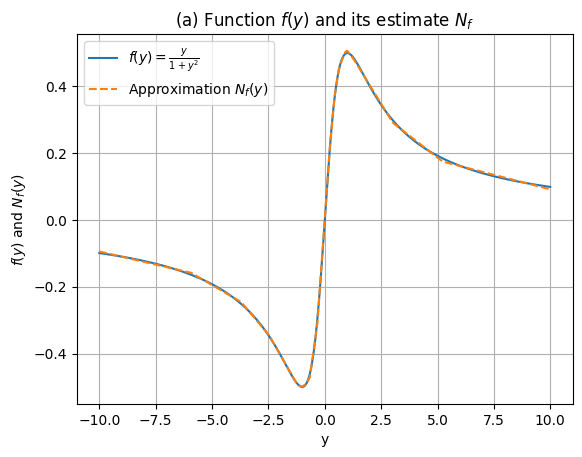

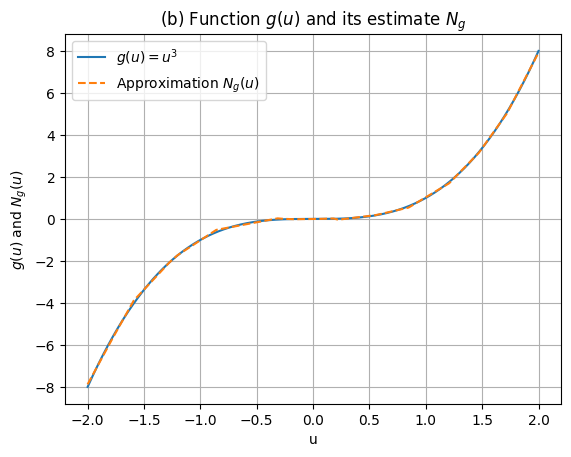

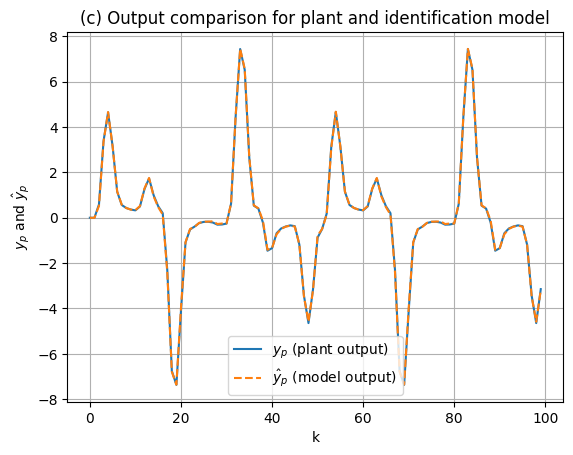

In [5]:
# Plot function f and its approximation N_f (Figure a)
plt.figure()
plt.plot(y_values, f_values, label=r'$f(y) = \frac{y}{1 + y^2}$')
plt.plot(y_values, f_pred, '--', label=r'Approximation $N_f(y)$')
plt.xlabel('y')
plt.ylabel(r'$f(y)$ and $N_f(y)$')
plt.legend()
plt.title('(a) Function $f(y)$ and its estimate $N_f$')
plt.grid()

# Plot function g and its approximation N_g (Figure b)
plt.figure()
plt.plot(u_values, g_values, label=r'$g(u) = u^3$')
plt.plot(u_values, g_pred, '--', label=r'Approximation $N_g(u)$')
plt.xlabel('u')
plt.ylabel(r'$g(u)$ and $N_g(u)$')
plt.legend()
plt.title('(b) Function $g(u)$ and its estimate $N_g$')
plt.grid()

# Simulate the plant and model outputs for Figure (c)
k_values = np.arange(0, 100)
u_k = np.sin(2 * np.pi * k_values / 25) + np.sin(2 * np.pi * k_values / 10)
yp = np.zeros_like(k_values, dtype=float)
yp_hat = np.zeros_like(k_values, dtype=float)

# Initial values
yp[0] = 0
yp_hat[0] = 0

# Simulate the system using the neural networks
for k in range(1, len(k_values)):
    # Plant output
    yp[k] = yp[k-1] / (1 + yp[k-1] ** 2) + u_k[k-1] ** 3
    
    # Model output using neural network predictions
    f_val = net_f(torch.tensor([[yp_hat[k-1]]], dtype=torch.float32)).item()
    g_val = net_g(torch.tensor([[u_k[k-1]]], dtype=torch.float32)).item()
    yp_hat[k] = f_val + g_val

# Plot time series of plant output yp and model output yp_hat (Figure c)
plt.figure()
plt.plot(k_values, yp, label=r'$y_p$ (plant output)')
plt.plot(k_values, yp_hat, '--', label=r'$\hat{y}_p$ (model output)')
plt.xlabel('k')
plt.ylabel(r'$y_p$ and $\hat{y}_p$')
plt.legend()
plt.title('(c) Output comparison for plant and identification model')
plt.grid()

plt.show()